<a href="https://colab.research.google.com/github/Aswinisiva/ECG-Classification-Project/blob/main/ECG_Exploratory_data_analysis_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECG Project

Dataset Link : https://www.kaggle.com/datasets/erhmrai/ecg-image-data/data

## Download and Import the important Libraries

In [ ]:
!pip install -q pillow matplotlib

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Average
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc

## 1.0 **Data**

### 1.1 Data Download & Unzip

In [ ]:
!kaggle datasets download -d erhmrai/ecg-image-data

Dataset URL: https://www.kaggle.com/datasets/erhmrai/ecg-image-data
License(s): CC-BY-NC-SA-4.0
100% 856M/858M [00:43<00:00, 22.4MB/s]
100% 858M/858M [00:43<00:00, 20.9MB/s]


In [ ]:
!unzip -q ecg-image-data.zip

### 1.2 Data Visualisation

Train Data Samples:


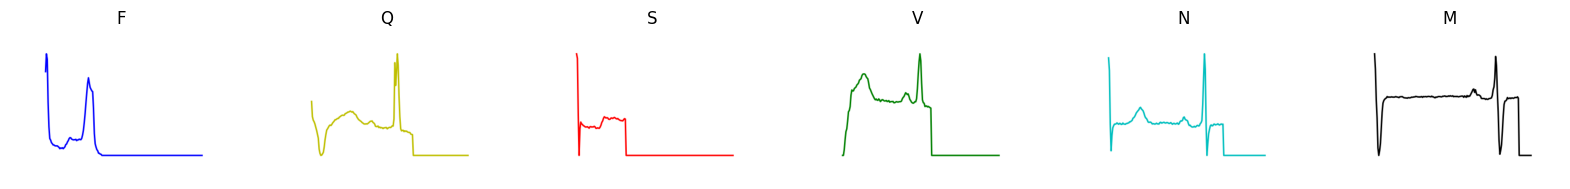

Test Data Samples:


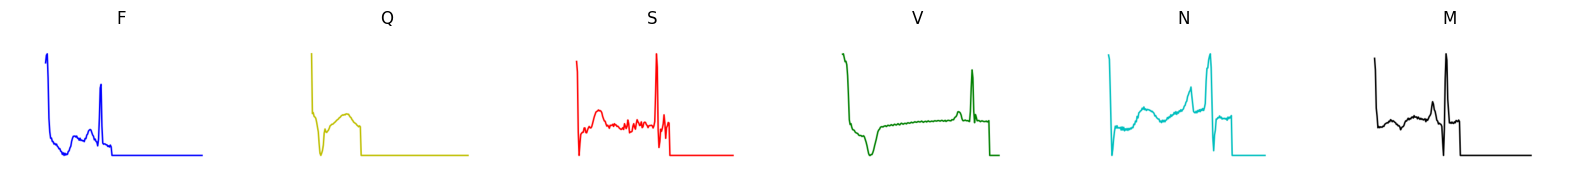

In [ ]:
# Data Visualisation
import os
from PIL import Image
import matplotlib.pyplot as plt

# Define the base directory for the dataset
base_dir = '/content/ECG_Image_data'

# Define the train and test directories
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Function to visualize one sample from each class
def visualize_one_sample_per_class(directory):
    classes = os.listdir(directory)
    fig, axes = plt.subplots(1, len(classes), figsize=(20, 5))

    for i, cls in enumerate(classes):
        class_dir = os.path.join(directory, cls)
        sample_image_path = os.path.join(class_dir, os.listdir(class_dir)[0])
        sample_image = Image.open(sample_image_path)
        axes[i].imshow(sample_image)
        axes[i].set_title(cls)
        axes[i].axis('off')

    plt.show()

# Visualize one sample from each class in the train directory
print("Train Data Samples:")
visualize_one_sample_per_class(train_dir)

# Visualize one sample from each class in the test directory
print("Test Data Samples:")
visualize_one_sample_per_class(test_dir)


Train Class Counts: {'F': 642, 'Q': 6431, 'S': 2223, 'V': 5789, 'N': 75709, 'M': 8405}


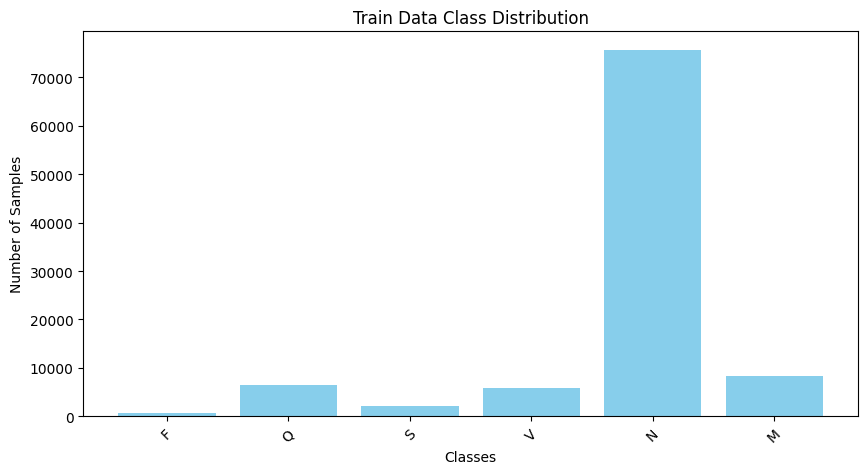

Test Class Counts: {'F': 161, 'Q': 1608, 'S': 556, 'V': 1447, 'N': 18926, 'M': 2101}


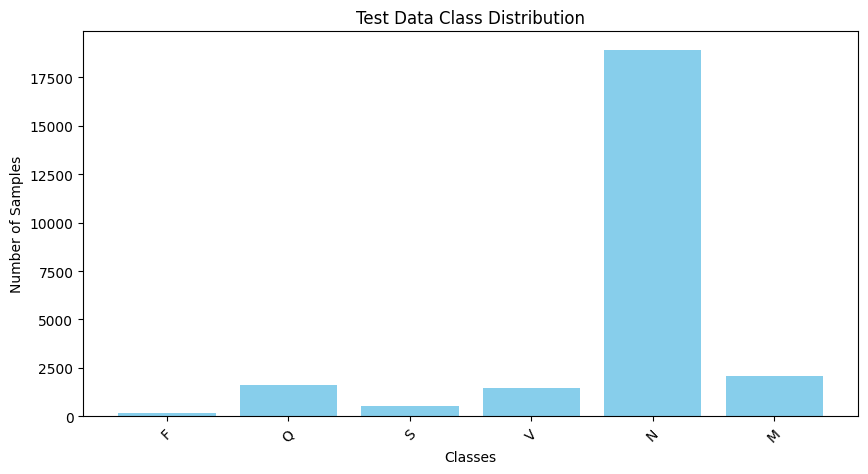

In [ ]:
import os
import matplotlib.pyplot as plt

# Define the base directory for the dataset
base_dir = '/content/ECG_Image_data'

# Define the train and test directories
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Function to count samples in each class
def count_samples_per_class(directory):
    class_counts = {}
    classes = os.listdir(directory)

    for cls in classes:
        class_dir = os.path.join(directory, cls)
        sample_count = len(os.listdir(class_dir))
        class_counts[cls] = sample_count

    return class_counts

# Function to visualize counts in a bar chart
def visualize_counts(class_counts, title):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 5))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Number of Samples')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

# Count samples in each class for the train directory
train_class_counts = count_samples_per_class(train_dir)
print("Train Class Counts:", train_class_counts)

# Visualize train class counts
visualize_counts(train_class_counts, 'Train Data Class Distribution')

# Count samples in each class for the test directory
test_class_counts = count_samples_per_class(test_dir)
print("Test Class Counts:", test_class_counts)

# Visualize test class counts
visualize_counts(test_class_counts, 'Test Data Class Distribution')

### 1.3 Normalisation of Dataset

Train Class Counts: {'F': 642, 'Q': 6431, 'S': 2223, 'V': 5789, 'N': 75709, 'M': 8405}
Normalized Train Class Counts: {'F': 642, 'Q': 642, 'S': 642, 'V': 642, 'N': 642, 'M': 642}


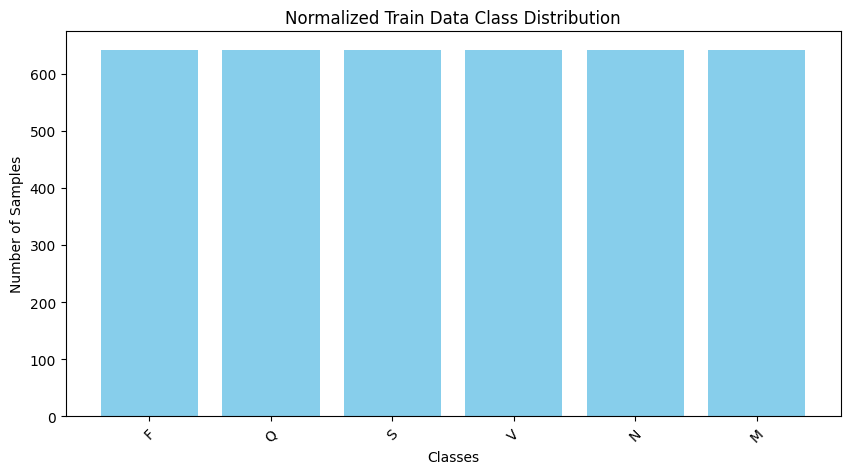

Test Class Counts: {'F': 161, 'Q': 1608, 'S': 556, 'V': 1447, 'N': 18926, 'M': 2101}
Normalized Test Class Counts: {'F': 161, 'Q': 161, 'S': 161, 'V': 161, 'N': 161, 'M': 161}


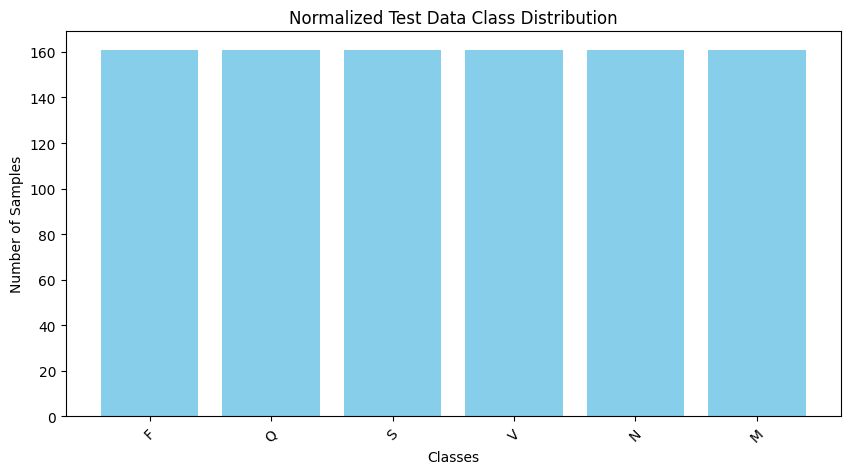

In [ ]:
import os
import random
import shutil
import matplotlib.pyplot as plt

# Define the base directory for the dataset
base_dir = '/content/ECG_Image_data'

# Define the train and test directories
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Function to count samples in each class
def count_samples_per_class(directory):
    class_counts = {}
    classes = os.listdir(directory)

    for cls in classes:
        class_dir = os.path.join(directory, cls)
        sample_count = len(os.listdir(class_dir))
        class_counts[cls] = sample_count

    return class_counts

# Function to normalize samples in each class
def normalize_samples_per_class(directory, min_samples):
    classes = os.listdir(directory)

    for cls in classes:
        class_dir = os.path.join(directory, cls)
        samples = os.listdir(class_dir)
        random.shuffle(samples)
        selected_samples = samples[:min_samples]

        # Create a new directory for normalized samples
        normalized_class_dir = os.path.join(directory + '_normalized', cls)
        os.makedirs(normalized_class_dir, exist_ok=True)

        # Copy selected samples to the new directory
        for sample in selected_samples:
            src = os.path.join(class_dir, sample)
            dst = os.path.join(normalized_class_dir, sample)
            shutil.copy(src, dst)

# Function to visualize counts in a bar chart
def visualize_counts(class_counts, title):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 5))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Number of Samples')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

# Count samples in each class for the train directory
train_class_counts = count_samples_per_class(train_dir)
print("Train Class Counts:", train_class_counts)

# Normalize train samples
min_train_samples = min(train_class_counts.values())
normalize_samples_per_class(train_dir, min_train_samples)

# Count normalized samples in each class for the train directory
normalized_train_dir = train_dir + '_normalized'
normalized_train_class_counts = count_samples_per_class(normalized_train_dir)
print("Normalized Train Class Counts:", normalized_train_class_counts)

# Visualize normalized train class counts
visualize_counts(normalized_train_class_counts, 'Normalized Train Data Class Distribution')

# Count samples in each class for the test directory
test_class_counts = count_samples_per_class(test_dir)
print("Test Class Counts:", test_class_counts)

# Normalize test samples
min_test_samples = min(test_class_counts.values())
normalize_samples_per_class(test_dir, min_test_samples)

# Count normalized samples in each class for the test directory
normalized_test_dir = test_dir + '_normalized'
normalized_test_class_counts = count_samples_per_class(normalized_test_dir)
print("Normalized Test Class Counts:", normalized_test_class_counts)

# Visualize normalized test class counts
visualize_counts(normalized_test_class_counts, 'Normalized Test Data Class Distribution')